In [1]:
import cv2
import glob
import numpy as np

import matplotlib.image as mpimg
from skimage.feature import hog
%matplotlib inline

In [2]:
######################################################################################################################
#  Following section return some characteristics of the dataset
######################################################################################################################
def data_look(car_list, notcar_list):
    data_dict = {}
    data_dict["n_cars"] = len(car_list)
    data_dict["n_notcars"] = len(notcar_list)
    example_img = mpimg.imread(car_list[0])
    data_dict["image_shape"] = example_img.shape
    data_dict["data_type"] = example_img.dtype
    return data_dict

Your function returned a count of 5968  cars and 5968  non-cars
of size:  (64, 64, 3)  and data type: float32


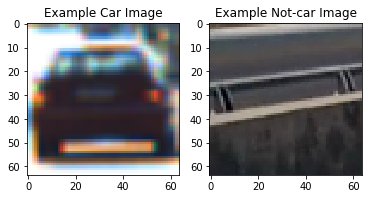

In [3]:
######################################################################################################################
#  Reading the images for Car and Non Car and also, storing them in numpy array, then printing different
#  statics of data
######################################################################################################################
veh_images = glob.glob('train_vehicle_images/*.png')
nonveh_images = glob.glob('train_nonvehicle_images/*.png')

cars = []
notcars = []

for vehimage in veh_images:
    cars.append(vehimage)
for nonvehimage in nonveh_images:
    notcars.append(nonvehimage)

data_info = data_look(cars, notcars)

print('Data Count : ',
      data_info["n_cars"], ' cars and',
      data_info["n_notcars"], ' non-cars')
print('of size: ', data_info["image_shape"], ' and data type:',
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

In [4]:
######################################################################################################################
#  Following section defines the feature extraction utility methods to extract the feature matrix
######################################################################################################################

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [5]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [6]:

def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # It returns the hog image if vis = true
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False,
                       visualise=vis, feature_vector=feature_vec)
        return features

In [7]:
# Following method uses the above utility methods to extract and bundle the whole feature matrix to use
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL'):
    # Create a list to append feature vectors to
    features = []

    # Iterate through the list of images
    for file in imgs:
        # Define the array which stores features for only 1 file
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)

        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)

        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)

        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)

        file_features.append(hog_features)

        # Append the new file feature matrix to the dataset features list
        features.append(np.concatenate(file_features))

    # Return list of feature vectors for the group of images which were stored in "imgs"
    return features

In [144]:
######################################################################################################################
#  Following section normalizes and also splits the training and test data
######################################################################################################################

from sklearn.preprocessing import StandardScaler
import time
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 1
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()

# Extract the features for Cars and NonCars
car_features = extract_features(cars, cspace=colorspace, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                        hog_channel=hog_channel)

notcar_features = extract_features(notcars, cspace=colorspace, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                        hog_channel=hog_channel)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

## Scaler allows to normalize the data which is the combination of different kind of feature vectors.

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Defining the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

######################################################################################################################
#  Following section trains the classifier to be used
######################################################################################################################
# Use a linear SVC
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10

print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()

print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

80.03 Seconds to extract HOG features...


/Users/sulabhmatele/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Using: 16 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 12576
18.41 Seconds to train SVC...
Test Accuracy of SVC =  0.9987
My SVC predicts:  [ 0.  1.  1.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 0.  1.  1.  0.  0.  1.  0.  1.  1.  1.]
0.04019 Seconds to predict 10 labels with SVC


In [145]:
######################################################################################################################
#  Following are some utility methods which will be used in the final pipeline to process the video frames.
######################################################################################################################
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    else:
        return np.copy(img)

In [147]:
def printImageColors(car_image, clr = 'RGB2YUV'):
    img = convert_color(car_image, clr)
    
    c1,c2,c3 = cv2.split(img)
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10,10))
    ax1.imshow(car_image)
    ax1.set_title('Original Image', fontsize=10)
    ax2.imshow(c1)
    ax2.set_title('Color 1', fontsize=10)
    ax3.imshow(c2)
    ax3.set_title('Color 2', fontsize=10)
    ax4.imshow(c3)
    ax4.set_title('Color 3', fontsize=10)
    return img

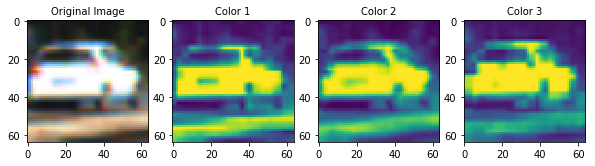

In [148]:
imgrgb = printImageColors(car_image, clr = '')

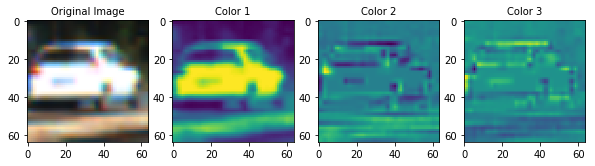

In [149]:
imgyuv = printImageColors(car_image, clr = 'RGB2YUV')

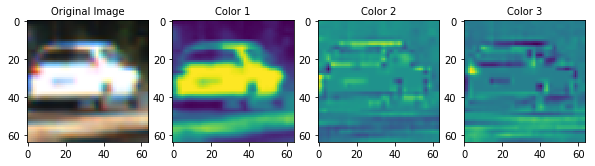

In [150]:
imgycrcb = printImageColors(car_image, clr = 'BGR2YCrCb')

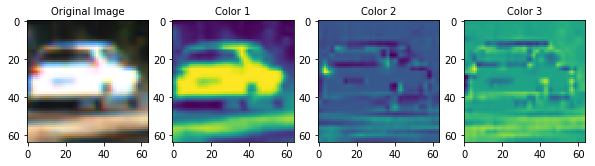

In [151]:
imgluv = printImageColors(car_image, clr = 'RGB2LUV')

In [9]:
def getHogImage(feature_image):
    ftr, hogCh1  = get_hog_features(feature_image[:,:,0],
                                    9, 8, 2,
                                    vis=True, feature_vec=False)
    ftr, hogCh2  = get_hog_features(feature_image[:,:,1],
                                9, 8, 2,
                                vis=True, feature_vec=False)

    ftr, hogCh3  = get_hog_features(feature_image[:,:,2],
                            9, 8, 2,
                            vis=True, feature_vec=False)

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10,10))
    ax1.imshow(feature_image)
    ax1.set_title('Color converted Image', fontsize=10)
    
    ax2.imshow(hogCh1)
    ax2.set_title('Hog imageCh1', fontsize=10)

    ax3.imshow(hogCh2)
    ax3.set_title('Hog imageCh2', fontsize=10)
    
    ax4.imshow(hogCh3)
    ax4.set_title('Hog imageCh3', fontsize=10)
    return hogCh1, hogCh2, hogCh3


(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.01592229, ...,  0.00131167,
          0.        ,  0.        ],
        [ 0.        ,  0.00651937,  0.        , ...,  0.        ,
          0.00130338,  0.        ],
        ..., 
        [ 0.        ,  0.02468697,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.02485513, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.00116618, ...,  0.00179271,
          0.        ,  0.        ],
        [ 0.        ,  0.00071343,  0.        , ...,  0.        ,
          0.00106118,  0.        ],
        ..., 
        [ 0.        ,  0.00341089,  0.        , ...,

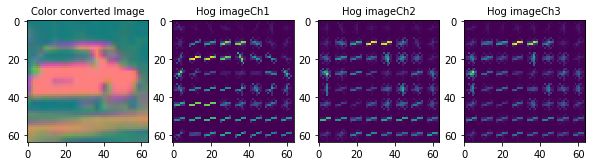

In [153]:
getHogImage(imgyuv)

(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.02653941, ...,  0.00158996,
          0.        ,  0.        ],
        [ 0.        ,  0.00246124,  0.        , ...,  0.        ,
          0.00351011,  0.        ],
        ..., 
        [ 0.        ,  0.03160976,  0.        , ...,  0.        ,
          0.00275956,  0.        ],
        [ 0.        ,  0.        ,  0.01106633, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.01199815, ...,  0.00101368,
          0.        ,  0.        ],
        [ 0.        ,  0.00449802,  0.        , ...,  0.        ,
          0.00163768,  0.        ],
        ..., 
        [ 0.        ,  0.02983118,  0.        , ...,

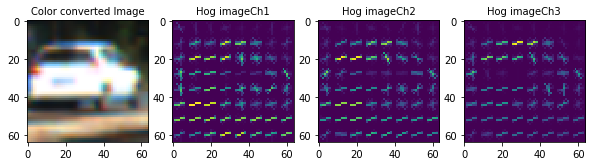

In [154]:
getHogImage(imgrgb)

(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.01592229, ...,  0.00131167,
          0.        ,  0.        ],
        [ 0.        ,  0.00651937,  0.        , ...,  0.        ,
          0.00130338,  0.        ],
        ..., 
        [ 0.        ,  0.02468697,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.02485513, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   4.86290242e-04, ...,
           1.93375308e-03,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   6.42903615e-04,   0.00000000e+00, ...,
           0.00000000e+00,   7.75190201e

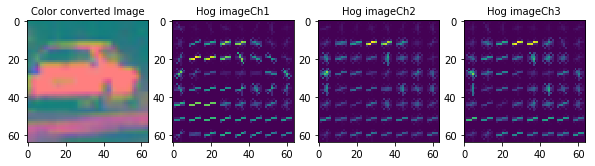

In [155]:
getHogImage(imgycrcb)

(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.00035729,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.00396273,  0.        ],
        ..., 
        [ 0.        ,  0.00025264,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.00188622, ...,  0.00166531,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.00037272, ...,  0.00208127,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.00669553,  0.        ],
        ..., 
        [ 0.        ,  0.00025264,  0.        , ...,

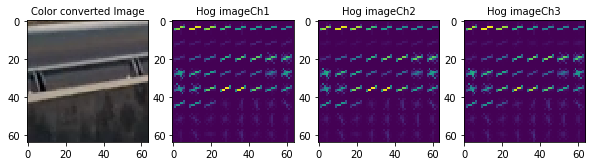

In [10]:
getHogImage(notcar_image)

In [157]:
def getImageHistogram(img):
    # Compute the histogram of the RGB channels separately

    rhist = np.histogram(img[:,:,0], bins=16, range=(0, 256))
    ghist = np.histogram(img[:,:,1], bins=16, range=(0, 256))
    bhist = np.histogram(img[:,:,2], bins=16, range=(0, 256))
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(img)
    plt.title('Original Converted Image')
    
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bin_centers, rhist[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bin_centers, ghist[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bin_centers, bhist[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()

    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers

((array([157751,  83670,  76124,  70831,  70108,  75633,  67468,  43478,
          38350,  32140,  60382, 100341,  31134,   3263,   4187,   6740]),
  array([   0.,   16.,   32.,   48.,   64.,   80.,   96.,  112.,  128.,
          144.,  160.,  176.,  192.,  208.,  224.,  240.,  256.])),
 (array([159445,  84467,  76824,  70503,  78272,  57822,  37408,  30084,
          37298,  67814, 131553,  62764,  17934,   2142,   3229,   4041]),
  array([   0.,   16.,   32.,   48.,   64.,   80.,   96.,  112.,  128.,
          144.,  160.,  176.,  192.,  208.,  224.,  240.,  256.])),
 (array([178257,  93609,  79733,  57548,  62355,  53206,  39021,  25530,
          30467,  99532,  78285,  29425,  53515,  34432,   3601,   3084]),
  array([   0.,   16.,   32.,   48.,   64.,   80.,   96.,  112.,  128.,
          144.,  160.,  176.,  192.,  208.,  224.,  240.,  256.])),
 array([   8.,   24.,   40.,   56.,   72.,   88.,  104.,  120.,  136.,
         152.,  168.,  184.,  200.,  216.,  232.,  248.]))

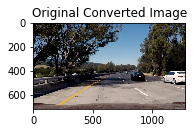

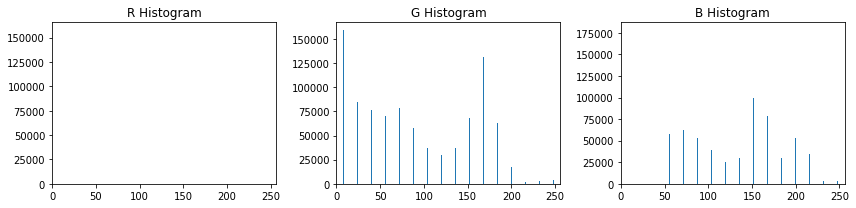

In [158]:
test_img = img = mpimg.imread('imgs/test5.jpg') 
getImageHistogram(test_img)

In [159]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [160]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [161]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


In [162]:
######################################################################################################################

from scipy.ndimage.measurements import label

######################################################################################################################
#  find_cars - method implements the main sliding window method which detects the cars and returns the
#  detected rectangle coordinates
######################################################################################################################
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    # make a copy of the input image
    draw_img = np.copy(img)
    # Normalize the image
    img = (img.astype(np.float32) / 255) - 0.5
    # Define the window to search
    img_tosearch = img[ystart:ystop, :, :]
    # Convert to required color space, this is same as used of training
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')

    # Scale the image accordingly.
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient * cell_per_block ** 2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1

    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    box_list = []

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (32, 32))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                box_list.append(
                    ((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))

    return draw_img, box_list

In [163]:
def addHeatFeature(draw_img, box_list):
    heat = np.zeros_like(draw_img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,4)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    return draw_img, heatmap

In [164]:
def drawHeatMap(draw_img, heatmap):
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw_img, labels)
    
    return draw_img

In [165]:
# Define a data structure to store the already detected heatmap
import collections
heatmaps = collections.deque(maxlen=10)

In [172]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

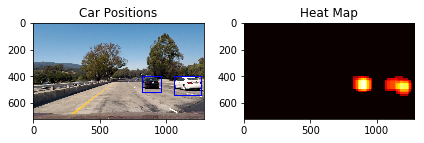

In [187]:
ystart = 400
ystop = 656
scale = 1.5
spatial_size=(32, 32)
hist_bins=32

img = mpimg.imread('imgs/test1.jpg')  

heatmaps.clear()
draw_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
draw_img, current_heatmap = addHeatFeature(draw_img, box_list)
# heatmaps.append(current_heatmap)
# heatmap = sum(heatmaps)/len(heatmaps)

labels = label(current_heatmap)
draw_img = draw_labeled_bboxes(np.copy(draw_img), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(current_heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [168]:
# Following method is called by video utility to process the video frame to get the processed image
def detectCars(img):
    ystart = 400
    ystop = 656
    scale = 1.5
    spatial_size=(32, 32)
    hist_bins=32
    draw_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    draw_img, current_heatmap = addHeatFeature(draw_img, box_list)
    heatmaps.append(current_heatmap)
    heatmap = sum(heatmaps)/len(heatmaps)
    out_img = drawHeatMap(draw_img, heatmap)
    return out_img

In [169]:
# Following code processes the given video's each frame with the LaneLine finding pipeline and creates the
# resulted video
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def createOutVideo():
    heatmaps.clear()
    white_output = 'project_result.mp4'
    clip1 = VideoFileClip("project_video.mp4").subclip(20,27)
    white_clip = clip1.fl_image(detectCars) #NOTE: this function expects color images!!
    white_clip.write_videofile(white_output, audio=False)
    return white_clip

In [170]:
white_clip = createOutVideo()

[MoviePy] >>>> Building video project_result.mp4
[MoviePy] Writing video project_result.mp4


 99%|█████████▉| 175/176 [03:11<00:00,  1.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_result.mp4 

